#### Imports

In [1]:
import glob

from osgeo import gdal

%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import rasterio
from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm
import tifffile as sktif

# import shapely.wkt
import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *
import ujson as json
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


W1001 21:57:29.421458 139863628629824 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/metrics.py:103: The name tf.keras.metrics.cosine_proximity is deprecated. Please use tf.keras.losses.cosine_similarity instead.

W1001 21:57:29.462121 139863628629824 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/_keras_losses.py:104: The name tf.keras.losses.cosine is deprecated. Please use tf.keras.losses.cosine_similarity instead.



#### Files

In [2]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"

In [4]:
metadata_df = pd.read_csv(data_dir/"train"/"metdata.csv",  index_col='id')

In [5]:
metadata_df.head()

,sensor,provider_asset_type,gsd,capture_date,off_nadir_angle,pan_resolution,sun_azimuth,sun_elevation,target_azimuth,disaster,disaster_type,catalog_id,original_width,original_height,width,height,img_name
id,,,,,,,,,,,,,,,,,
MjU4MDE3OA.vigoXx_P7tlDKfvwJzQ1nrrupIc,WORLDVIEW02,WORLDVIEW02,2.570075,2018-11-14T18:42:58.000Z,32.674200,0.643838,163.31218,35.885086,334.12890,socal-fire,fire,103001008513F200,1024,1024,1024,1024,socal-fire_00000521_post_disaster.png
MjE5Nzc5MA.m3CJXOd-mkKwPckmnN2HXJrZ8dQ,WORLDVIEW02,WORLDVIEW02,2.066485,2017-11-29T16:28:19.000Z,19.816387,0.516751,162.03100,35.949000,285.76627,hurricane-michael,wind,1030010075CC2C00,1024,1024,1024,1024,hurricane-michael_00000047_pre_disaster.png
MjU3NzI5NA.xXAyToVXpsDLRlmiil7ERxQfsao,WORLDVIEW02,WORLDVIEW02,1.989496,2018-10-23T18:51:02.000Z,15.396526,0.498313,163.75761,42.667400,333.27460,socal-fire,fire,1030010088D86900,1024,1024,1024,1024,socal-fire_00001003_pre_disaster.png
MjU4MDIzOA.yYVJwy8u7xcp4JFTijIVJloYFYw,WORLDVIEW02,WORLDVIEW02,2.570075,2018-11-14T18:42:58.000Z,32.674200,0.643838,163.31218,35.885086,334.12890,socal-fire,fire,103001008513F200,1024,1024,1024,1024,socal-fire_00000580_post_disaster.png
MjU4MDMzMA.FxeSXSVYWtuXyCXeLboTXawiZX0,WORLDVIEW02,WORLDVIEW02,2.570075,2018-11-14T18:42:58.000Z,32.674200,0.643838,163.31218,35.885086,334.12890,socal-fire,fire,103001008513F200,1024,1024,1024,1024,socal-fire_00000671_post_disaster.png


In [6]:
metadata_df.shape

(5598, 17)

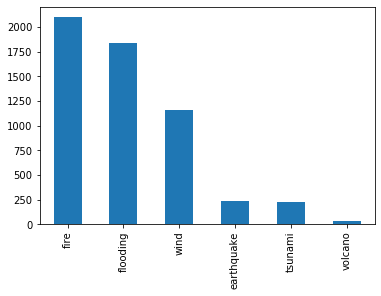

In [7]:
metadata_df.disaster_type.value_counts().plot.bar()